# Computer Vision for License Plate Recognition
The objective of this challenge is to make use of `object detection` and `image classification` to tell the values on the number plates (`Tunisian`) of a car from its image

## Approach
- create two models
- one to detect license plates
- another to detect and numbers in the license plates

In [1]:
## matrix and dataframe packages
import numpy as np
import pandas as pd

## image packages
import PIL as pil
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## deep learning packages
import torch
import torchvision.models as models
import torchvision.transforms as torch_transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## optical character recognition
import easyocr

## utility packages
import os
from datetime import datetime
import re

### Unzipping Files

### Preparing paths

In [2]:
data_path = "/kaggle/input/computer-vision-for-license-plate-recognition/"
figs_path = "/kaggle/working/figures/"
models_path = "/kaggle/input/ocr-model/"

## images path
detection_imgs_path = f"{data_path}/license_plates_detection_train/license_plates_detection_train/"
recognition_imgs_path = f"{data_path}/license_plates_recognition_train/license_plates_recognition_train/"
test_path = f"{data_path}/test/test_private/"

## annotations path
detection_annots = f"{data_path}/license_plates_detection_train.csv"
recognition_annots = f"{data_path}/license_plates_recognition_train.csv"

### Checking whether all images are unique

In [3]:
pd.read_csv(detection_annots).nunique()

img_id    900
ymin      293
xmin      412
ymax      286
xmax      413
dtype: int64

### Creating Datasets

In [4]:
temp = pd.read_csv(recognition_annots)

In [5]:
temp

,img_id,text
0,0.jpg,117T3989
1,1.jpg,128T8086
2,10.jpg,94T3458
3,100.jpg,133T6719
4,101.jpg,68T5979
...,...,...
895,95.jpg,39T8707
896,96.jpg,92T589
897,97.jpg,180T706
898,98.jpg,87T7369


In [47]:
class DetectionImagesDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.annots = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.unique_imgs = self.annots["img_id"].unique()

    def __len__(self):
        return len(self.annots)

    def __getitem__(self, idx):
        img_name = self.unique_imgs[idx]
        image = pil.Image.open(f"{self.img_dir}/{img_name}").convert("RGB")
        boxes = self.annots[self.annots["img_id"] == img_name][["xmin","ymin","xmax","ymax"]].values.astype(np.float32)
        labels = torch.ones((boxes.shape[0]), dtype=torch.int64)
        target = {"boxes": torch.from_numpy(boxes),
                  "labels": labels
                 }

        ## getting dimensions of the image
        init_img_shape = image.size

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target, init_img_shape)

        return image, target

class RecognitionImagesDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.annots = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.unique_imgs = self.annots["img_id"].unique()

    def __len__(self):
        return len(self.annots)

    def __getitem__(self, idx):
        img_name = self.unique_imgs[idx]
        image = pil.Image.open(f"{self.img_dir}/{img_name}")
        label = self.annots[self.annots["img_id"] == img_name]["text"].values[0].strip().split("T")
        target = torch.zeros((7,10), dtype=torch.int64)
        
        label="".join([label[0].rjust(3, "0"), label[1].rjust(4, "0")])
        
        for i, l in enumerate(label):
            target[i][int(l)] = 1
        

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target, init_img_shape)
            

        return image, target

class TestImagesDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.imgs_list = os.listdir(self.img_dir)
        
    def __len__(self):
        return len(self.imgs_list)
    
    def __getitem__(self, idx):
        img_name = self.imgs_list[idx]
        image = pil.Image.open(f"{self.img_dir}/{img_name}")
        
        if self.transform:
            image = self.transform(image)
            
        return img_name, image

## Processors

In [61]:
def process_ocr_pred(pred):
    for i in range(len(pred)):
        pred[i] = re.sub(r"\D", "", pred[i])
    if len(pred) > 1:
        pred = pred[:2]
        if len(pred[0]) > 3:
            pred[0] = pred[0][:3]
        else:
            pred[0].rjust(3, "0")
            
        if len(pred[1]) > 4:
            pred[1] = pred[1][1:]
        else:
            pred[1].rjust(4, "0")
    elif len(pred) == 1:
        if len(pred[0]) > 7:
            pred = [pred[0][:3], pred[0][-4:]]
    else:
        pred = ["0"]
        
    pred = "".join(pred).rjust(7,"0")
    

    
    target = torch.zeros((7,10), dtype=torch.int64)
    
    
    for i, l in enumerate(pred):
            target[i][int(l)] = 1
    
        
    
    return target

### Instantiating Datasets

In [48]:
resize_shape = (224, 224)

data_transform = torch_transforms.Compose([torch_transforms.Resize(resize_shape, interpolation=torch_transforms.InterpolationMode.BICUBIC),
                                           torch_transforms.ToTensor()
                                          ])

def target_transform(target, init_shape, resize_shape=resize_shape):
    x_scale = resize_shape[0]/init_shape[0]
    y_scale = resize_shape[1]/init_shape[1]
    target["boxes"][0][0] = x_scale * target["boxes"][0][0]
    target["boxes"][0][1] = y_scale * target["boxes"][0][1]
    target["boxes"][0][2] = x_scale * target["boxes"][0][2]
    target["boxes"][0][3] = y_scale * target["boxes"][0][3]
    return target


train_dataset = DetectionImagesDataset(detection_annots, detection_imgs_path, transform=data_transform, target_transform=target_transform)
train_recognition_dataset = RecognitionImagesDataset(recognition_annots, recognition_imgs_path)
test_dataset = TestImagesDataset(test_path, transform=data_transform)

Progress: |██████████████████████████████████████████████████| 100.0% Completetensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])


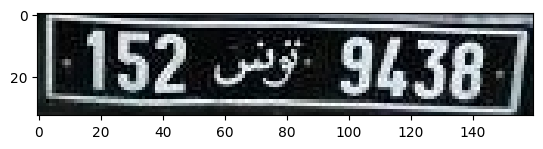

In [9]:
ind = np.random.randint(len(train_recognition_dataset))
img, label = train_recognition_dataset[ind]
reader = easyocr.Reader(["ar"], gpu=True)
ocr_res = reader.readtext(img,
                          allowlist='0123456789',
                          max_candidates=2,
                          detail=0,
                          text_threshold=0.7
                         )

print(process_ocr_pred(ocr_res))
plt.imshow(img)

In [10]:
train_dataset[32]

(tensor([[[0.0118, 0.0235, 0.0196,  ..., 0.0157, 0.0196, 0.0392],
          [0.0118, 0.0235, 0.0235,  ..., 0.0196, 0.0275, 0.0431],
          [0.0118, 0.0235, 0.0275,  ..., 0.0314, 0.0353, 0.0471],
          ...,
          [0.4157, 0.4471, 0.4902,  ..., 0.4706, 0.4549, 0.4549],
          [0.4275, 0.4667, 0.4941,  ..., 0.4588, 0.4510, 0.4549],
          [0.4549, 0.4824, 0.4824,  ..., 0.4510, 0.4431, 0.4549]],
 
         [[0.0118, 0.0235, 0.0196,  ..., 0.0157, 0.0196, 0.0392],
          [0.0118, 0.0235, 0.0235,  ..., 0.0196, 0.0275, 0.0431],
          [0.0118, 0.0235, 0.0275,  ..., 0.0314, 0.0353, 0.0471],
          ...,
          [0.3608, 0.3765, 0.4039,  ..., 0.3765, 0.3686, 0.3804],
          [0.3686, 0.3961, 0.4078,  ..., 0.3686, 0.3647, 0.3804],
          [0.3725, 0.4039, 0.3922,  ..., 0.3725, 0.3686, 0.3882]],
 
         [[0.0118, 0.0235, 0.0235,  ..., 0.0157, 0.0196, 0.0392],
          [0.0118, 0.0235, 0.0275,  ..., 0.0196, 0.0275, 0.0431],
          [0.0118, 0.0235, 0.0353,  ...,

## Visualizing data from dataset to make sure bounding box still at right position

In [11]:
def draw_img_with_box(img, boxes, pred_boxes=[], save_name=None):
    global figs_path
    fig, ax = plt.subplots()
    ax.imshow(img.permute(1,2,0))
    
    for box in boxes:
        x1, y1, x2, y2 = box.numpy().flatten()
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=1, edgecolor="g", facecolor="none")
        ax.add_patch(rect)
        
    if len(pred_boxes) > 0:
        for box in pred_boxes:
            x1, y1, x2, y2 = box.numpy().flatten()
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=1, edgecolor="r", facecolor="none")
            ax.add_patch(rect)
            
    if not os.path.exists(figs_path):
        os.mkdir(figs_path)
         
    if save_name:
        plt.savefig(os.path.join(figs_path, save_name))
    else:
        plt.show()

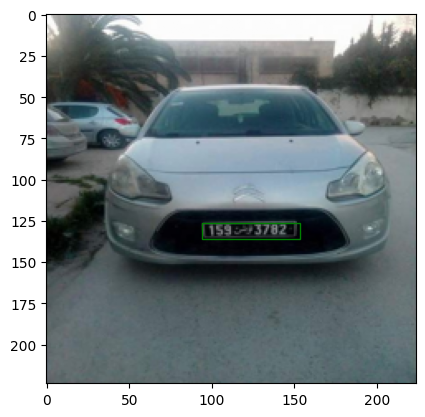

In [12]:
# img, target = train_dataset[np.random.randint(len(train_dataset))]
img, target = train_dataset[8]
draw_img_with_box(img, target["boxes"])

### Splitting dataset into `train` and `validation`

In [13]:
generator = torch.Generator().manual_seed(42)
train_detection_dataset, validation_detection_dataset = torch.utils.data.random_split(train_dataset,[.7,.3], generator=generator)

In [14]:
len(train_detection_dataset)

630

In [15]:
len(validation_detection_dataset)

270

### Creating Data Loaders

In [16]:
def collate_fn(data):
    return data

In [17]:
train_detection_loader = torch.utils.data.DataLoader(train_detection_dataset,
                                                     batch_size=8,
                                                     collate_fn=collate_fn,
                                                     shuffle=True,
                                                     pin_memory=True if torch.cuda.is_available() else False
                                          )
validation_detection_loader = torch.utils.data.DataLoader(validation_detection_dataset,
                                                          batch_size=8,
                                                          collate_fn=collate_fn,
                                                          pin_memory=True if torch.cuda.is_available() else False
                                          )

### Getting the pretrained model

In [18]:
fastercnn = fasterrcnn_resnet50_fpn(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 152MB/s]  


#### Changing the scoring head

In [19]:
in_features = fastercnn.roi_heads.box_predictor.cls_score.in_features
num_classes=2

fastercnn.roi_heads.box_predictor=FastRCNNPredictor(in_features, num_classes)

state_dict_path = "/kaggle/working/models/plate_detection_state_dict.pth"
if os.path.exists(state_dict_path):
    print(fastercnn.load_state_dict(torch.load(state_dict_path)))

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

### Instantiating optimizer

In [23]:
optimizer = torch.optim.SGD(fastercnn.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

### Moving model to device

In [24]:
fastercnn.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Training Function

In [25]:
def batch_gd(model, optimizer, train_loader, validation_loader=None, epochs=8):
    train_losses = []
    validation_losses = []
    for it in range(epochs):
        t0 = datetime.now()
        epoch_losses = []
        ## training
        model.train()
        for item in train_loader:
            optimizer.zero_grad()
            imgs = []
            targets = []
            for img, target in item:
                targets.append({"boxes": target["boxes"].to(device), "labels": target["labels"].to(device)})
                imgs.append(img.to(device))

            loss_dict = model(imgs, targets)
            loss = sum(v for v in loss_dict.values())
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        train_losses.append(np.mean(epoch_losses))

        ## evaluating
        if validation_loader:
            epoch_losses=[]
#             model.eval()
            with torch.no_grad():
                for item in validation_loader:
                    imgs = []
                    targets = []
                    for img, target in item:
                        targets.append({"boxes": target["boxes"].to(device), "labels": target["labels"].to(device)})
                        imgs.append(img.to(device))

                    loss_dict = model(imgs, targets)
                    loss = sum(v for v in loss_dict.values())

            validation_losses.append(loss.item())




        dt = datetime.now() - t0

        print(f"Epoch {it+1}/{epochs} Train Loss: {train_losses[it]}, Validation Loss: {validation_losses[it]} duration: {dt}")

    return train_losses, validation_losses

In [26]:
train_losses, validation_losses = batch_gd(fastercnn, optimizer, train_detection_loader, validation_loader=validation_detection_loader)

Epoch 1/8 Train Loss: 0.1932607084701333, Validation Loss: 0.1513979434967041 duration: 0:01:31.378526
Epoch 2/8 Train Loss: 0.09350826935488966, Validation Loss: 0.11500878632068634 duration: 0:01:21.839213
Epoch 3/8 Train Loss: 0.067201417269586, Validation Loss: 0.08785858750343323 duration: 0:01:21.899694
Epoch 4/8 Train Loss: 0.05934680663520777, Validation Loss: 0.08373170346021652 duration: 0:01:21.823397
Epoch 5/8 Train Loss: 0.052071601718286925, Validation Loss: 0.07838348299264908 duration: 0:01:21.686041
Epoch 6/8 Train Loss: 0.04841293620912335, Validation Loss: 0.06795834749937057 duration: 0:01:21.533954
Epoch 7/8 Train Loss: 0.04611421885746944, Validation Loss: 0.06872912496328354 duration: 0:01:21.670666
Epoch 8/8 Train Loss: 0.04415878347015079, Validation Loss: 0.07781392335891724 duration: 0:01:21.491935


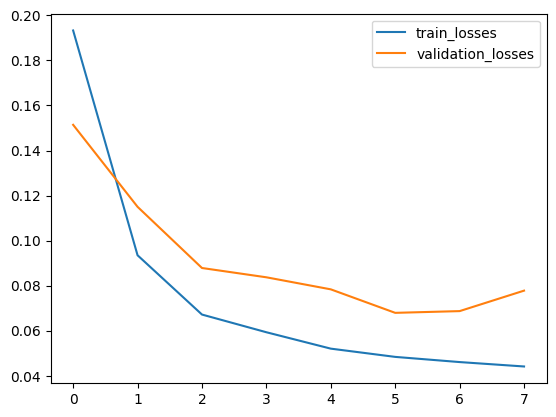

In [29]:
plt.plot(train_losses, label="train_losses")
plt.plot(validation_losses, label="validation_losses")
plt.legend()
plt.show()
# plt.savefig(os.path.join(figs_path, "detection_train_validation_loss.png"))

## Saving the `box predictor`

In [34]:
# save_dir = "/kaggle/working/models"

# if not os.path.exists(save_dir):
#     os.mkdir(save_dir)

# torch.save(fastercnn.state_dict(),
#            os.path.join(save_dir,"plate_detection_state_dict.pth"))

## Comparing predicted bounding boxes to actual boxes

### On training dataset

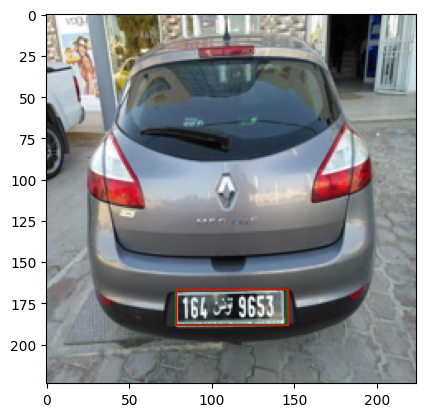

In [36]:
fastercnn.eval()
with torch.no_grad():
    random_ind = np.random.randint(len(train_dataset))
    img, target = train_dataset[random_ind]

    pred = fastercnn(img.unsqueeze(0).to(device))[0]
    draw_img_with_box(img, target["boxes"], pred_boxes=pred["boxes"].cpu(),
                      save_name="true_and_predicted_box")


In [37]:
fastercnn.eval()
data = iter(validation_detection_loader).__next__()

In [38]:
imgs = []
targets = []
for img, target in data:
    imgs.append(img.to(device))
    target["boxes"] = target["boxes"].to(device)
    target["labels"] = target["labels"].to(device)
    targets.append(target)

In [39]:
targets

[{'boxes': tensor([[ 74.8424, 193.6346, 139.4071, 216.5187]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0')},
 {'boxes': tensor([[154.4282,  31.4633, 172.0847, 123.0356]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0')},
 {'boxes': tensor([[113.0541, 107.5388, 154.9553, 132.4277]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0')},
 {'boxes': tensor([[ 78.1268, 112.6143, 149.1512, 125.3090]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0')},
 {'boxes': tensor([[ 71.0244, 126.5375, 127.2976, 137.5941]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0')},
 {'boxes': tensor([[ 79.7659, 136.3656, 148.6049, 151.1079]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0')},
 {'boxes': tensor([[ 50.0850, 118.7569,  75.5885, 133.9086]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0')},
 {'boxes': tensor([[166.5405,  94.1865, 179.4458, 149.4698]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0')}]

In [40]:
with torch.no_grad():
    valid_preds = fastercnn(imgs)

## Visualizing detection on validation data

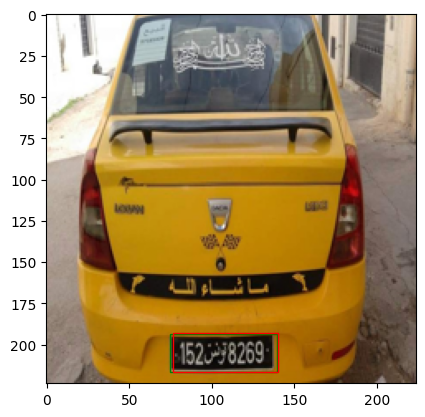

In [41]:
ind = 0
draw_img_with_box(imgs[ind].detach().cpu(), targets[ind]["boxes"].cpu(), pred_boxes=valid_preds[ind]["boxes"].cpu())

## Criterion for recognition

In [42]:
def recignition_criteria(target, pred):
    (target != pred).sum()

## Detecting and Recognizing

In [43]:
def read_plate_text(img, box, reader):
    x1,y1,x2,y2 = box.cpu().numpy().astype(np.int64)
    plate_img = torch_transforms.functional.crop(img.cpu(), y1, x1, y2-y1, x2-x1)
    plate_img = (plate_img.permute(1,2,0).numpy()*255).astype(np.uint8)
    
    if plate_img.shape[0] > plate_img.shape[1]:
        plate_img = np.rot90(plate_img, k=3)
    
    
    ocr_res = reader.readtext(plate_img,
                          allowlist='0123456789',
                          max_candidates=2,
                          detail=0,
                          text_threshold=0.6
                         )
    

    return process_ocr_pred(ocr_res)

In [44]:
reader = easyocr.Reader(["ar"], gpu=True)
read_plate_text(imgs[ind], valid_preds[ind]["boxes"][0], reader)

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

## Checking Recognition Performance on Validation data

In [ ]:
# validation_recognition_losses = []
# with torch.no_grad():
#     fastercnn.eval()
#     for item in validation_detection_loader:
#         imgs = []
#         targets = []
#         for img, target in item:
#             targets.append({"boxes": target["boxes"].to(device), "labels": target["labels"].to(device)})
#             imgs.append(img.to(device))

#         loss_dict = model(imgs, targets)
#         loss = sum(v for v in loss_dict.values())

## Prediction for test images

In [86]:
test_predictions = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        img_name, img = test_dataset[i]
        img_name = img_name.split(".")[0]
        img = img.to(device).unsqueeze(0)
        boxes = fastercnn(img)[0]["boxes"]
        if len(boxes) > 0:
            plate_matrix = read_plate_text(img[0], boxes[0], reader)
        else: plate_matrix = torch.zeros((7,10), dtype=torch.int64)
            
        plate_matrix = plate_matrix.numpy()

        for j in range(len(plate_matrix)):
            row = list(plate_matrix[j])
            row.insert(0, f"img_{img_name}_{j+1}")
            test_predictions.append(row)

## Making submissions

In [87]:
submission_dir = "/kaggle/working/submissions/"

if not os.path.exists(submission_dir):
    os.mkdir(submission_dir)

submission_df = pd.DataFrame(test_predictions, columns=["id", 0,1,2,3,4,5,6,7,8,9])
submission_df

,id,0,1,2,3,4,5,6,7,8,9
0,img_1075_1,0,1,0,0,0,0,0,0,0,0
1,img_1075_2,0,0,0,0,0,0,0,0,1,0
2,img_1075_3,0,0,1,0,0,0,0,0,0,0
3,img_1075_4,0,0,0,1,0,0,0,0,0,0
4,img_1075_5,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1465,img_921_3,1,0,0,0,0,0,0,0,0,0
1466,img_921_4,1,0,0,0,0,0,0,0,0,0
1467,img_921_5,0,0,0,0,0,1,0,0,0,0
1468,img_921_6,0,0,0,0,0,1,0,0,0,0


In [89]:
submission_df.to_csv(os.path.join(submission_dir,"submission_1.csv"), index=False)